In [6]:
!pip install torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv networkx matplotlib

  Using cached torch_geometric-2.6.1-py3-none-any.whl.metadata (63 kB)
  Using cached torch_scatter-2.1.2-cp311-cp311-linux_x86_64.whl
  Using cached torch_sparse-0.6.18.tar.gz (209 kB)
  Preparing metadata (setup.py) ... done
  Using cached torch_cluster-1.6.3.tar.gz (54 kB)
  Preparing metadata (setup.py) ... done
  Using cached torch_spline_conv-1.2.2.tar.gz (25 kB)
  Preparing metadata (setup.py) ... done
Using cached torch_geometric-2.6.1-py3-none-any.whl (1.1 MB)
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp311-cp311-linux_x86_64.whl size=1123736 sha256=89f74e2071b21a21b0e34204a8673bb35812ea84c2127caba796a5854db2d08d
  Stored in directory: /root/.cache/pip/wheels/75/e2/1e/299c596063839303657c211f587f05591891cc6cf126d94d21
  Created wheel for torch-spline-conv: filename=torch_spline_conv-1.2.2-cp311-cp311-linux_x86_64.whl size=229223 sha256=4d8bb5c3ce5ea3e2be2e63e5b525d546c5d3eb8c291637690f27611eaf3690b0
  Stored in directory: /root/.cache/pip/wheels/25/16/8a/a

In [29]:
import torch
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import subgraph

# Function to visualize subgraph
def visualize_subgraph(data, user_idx, item_idx, behavior, ax, max_nodes=100):
    """
    Visualizes a subgraph showing the relationship between a user and item with a specific behavior type (click/buy).
    
    :param data: HeteroData object containing the graph.
    :param user_idx: User index to analyze.
    :param item_idx: Item index to analyze.
    :param behavior: Behavior type (click or buy).
    :param ax: Matplotlib Axes object for visualization.
    :param max_nodes: Maximum number of nodes to display in the subgraph.
    """
    # Debugging: Check the unique behavior values
    print("Unique behavior values:", torch.unique(data['user', 'item'].behavior))
    
    # Filter edges based on behavior
    behavior_filter = data['user', 'item'].behavior == behavior
    selected_edges = data['user', 'item'].edge_index[:, behavior_filter]
    
    # Debugging: Print how many edges are being selected for the behavior
    print(f"Number of edges for behavior {behavior}: {selected_edges.shape[1]}")

    # Get nodes involved in the behavior
    nodes = torch.cat([selected_edges[0], selected_edges[1]])  # Collect all unique nodes from selected edges
    unique_nodes = torch.unique(nodes)

    # Debugging: Check how many unique nodes exist for the given behavior
    print(f"Number of unique nodes for behavior {behavior}: {len(unique_nodes)}")

    # Limit the number of nodes to visualize
    unique_nodes = unique_nodes[:min(len(unique_nodes), max_nodes)]  # Limit to max_nodes

    # Get the subgraph (with relabeling of nodes)
    edge_index_subgraph, _ = subgraph(unique_nodes, data['user', 'item'].edge_index, relabel_nodes=True)
    
    # Debugging: Check the subgraph structure
    print(f"Subgraph edge_index shape: {edge_index_subgraph.shape}")

    # Create a NetworkX graph
    G = nx.Graph()
    
    # Add edges to the NetworkX graph
    for i in range(edge_index_subgraph.shape[1]):
        u, v = edge_index_subgraph[0, i].item(), edge_index_subgraph[1, i].item()
        G.add_edge(u, v)
    
    # Use a layout for node positioning (e.g., Kamada-Kawai layout)
    pos = nx.spring_layout(G, iterations=10)  # Reduced iterations for faster computation
    
    # Draw the graph on the given axes
    nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10, font_weight='bold', ax=ax)
    ax.set_title(f"Behavior: {behavior}")

# Example usage
user_idx = 0  # Example user index
item_idx = 0  # Example item index

# Assuming data is loaded properly as HeteroData
data = torch.load('/kaggle/input/graph-dataset/processed_data.pt')  # Without weights_only=True

fig, ax = plt.subplots(1, 2, figsize=(15, 8))

# Visualize click (behavior=0) with a limited number of nodes
visualize_subgraph(data, user_idx, item_idx, behavior=0, ax=ax[0], max_nodes=100)

# Visualize buy (behavior=2) with a limited number of nodes
visualize_subgraph(data, user_idx, item_idx, behavior=2, ax=ax[1], max_nodes=100)

plt.show()

Total purchase edges: 101182
Top users by purchase count: [(42101, 175), (36725, 62), (28139, 60), (43962, 56), (35170, 52)]
Graph has 89 nodes and 84 edges


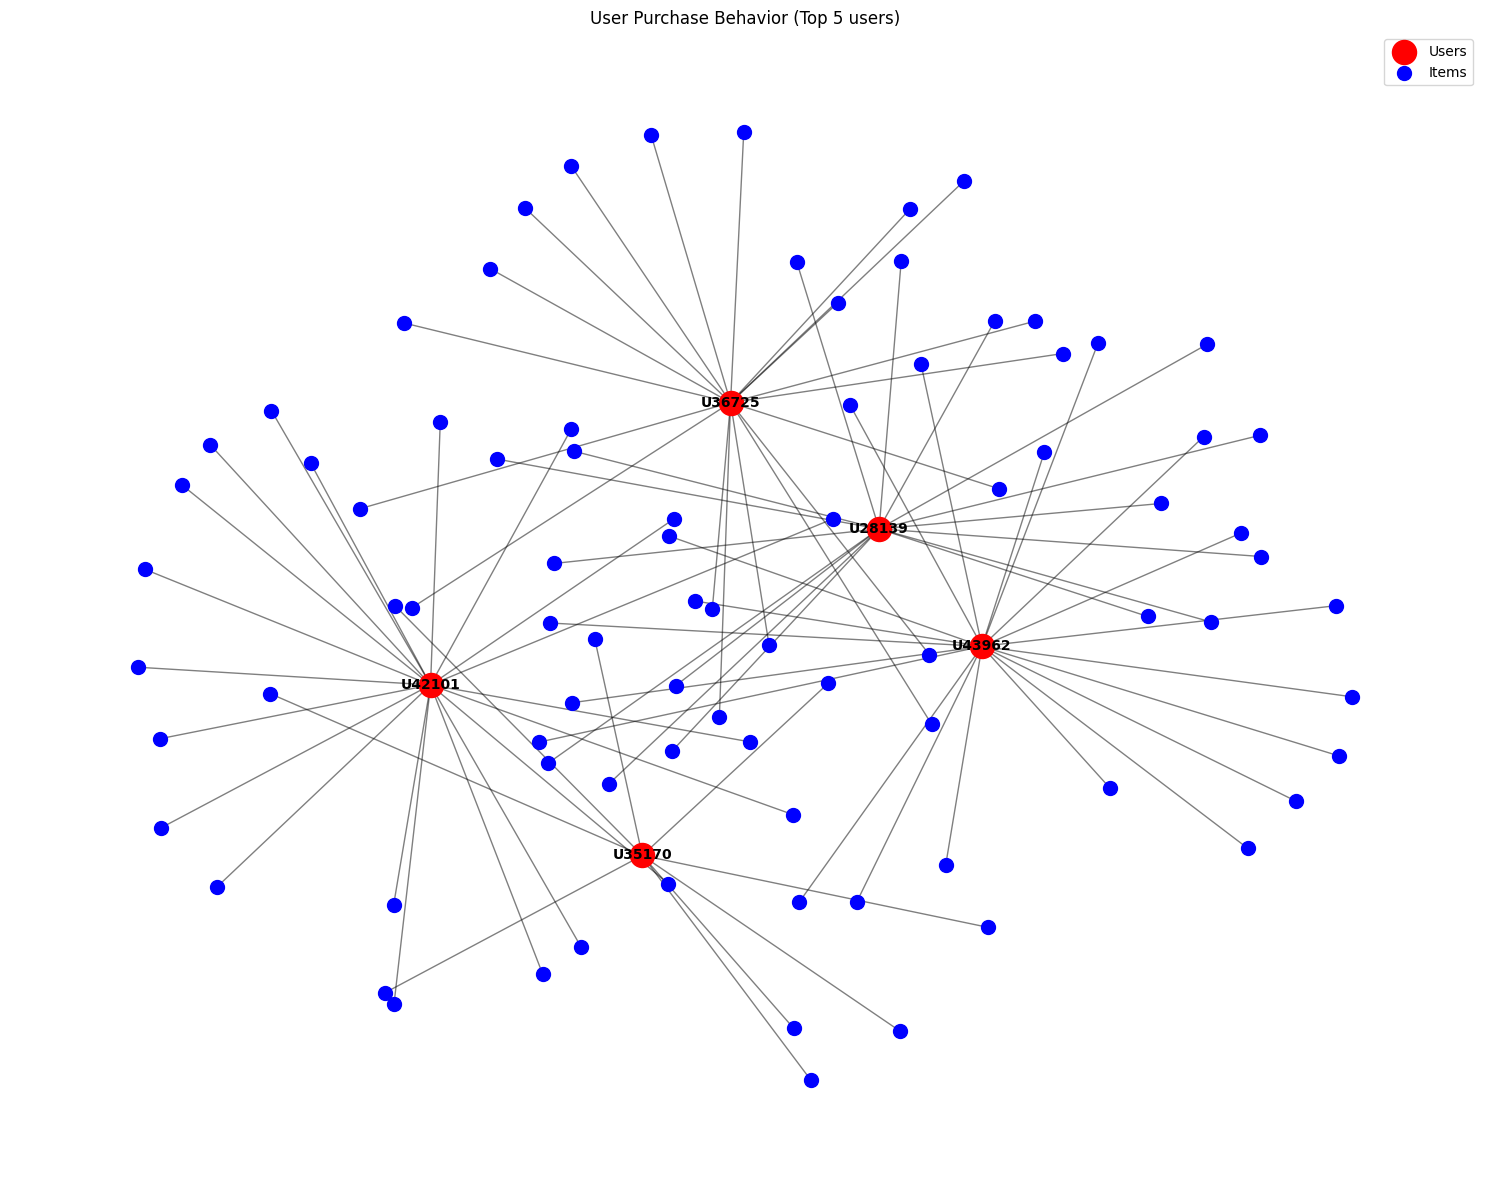

In [37]:
def visualize_user_purchases(data, num_users=5, ax=None, behavior=2, max_items_per_user=20):
    """
    Visualizes a subgraph focused on specific users and their purchased items.
    
    :param data: HeteroData object containing the graph
    :param num_users: Number of users to visualize
    :param ax: Matplotlib axes for plotting
    :param behavior: Behavior type (2 for purchases)
    :param max_items_per_user: Maximum number of items to show per user
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 10))
    
    # Filter edges for the specified behavior (purchases)
    behavior_filter = data['user', 'item'].behavior == behavior
    purchase_edges = data['user', 'item'].edge_index[:, behavior_filter]
    
    print(f"Total purchase edges: {purchase_edges.shape[1]}")
    
    # Find users with the most purchases
    user_counts = {}
    for i in range(purchase_edges.shape[1]):
        user = purchase_edges[0, i].item()
        user_counts[user] = user_counts.get(user, 0) + 1
    
    # Sort users by purchase count and take top ones
    top_users = sorted(user_counts.items(), key=lambda x: x[1], reverse=True)[:num_users]
    top_user_ids = [user for user, count in top_users]
    
    print(f"Top users by purchase count: {top_users}")
    
    # Create a NetworkX graph
    G = nx.Graph()
    
    # For each top user, add their purchased items
    for user_id in top_user_ids:
        user_mask = purchase_edges[0] == user_id
        user_purchases = purchase_edges[:, user_mask]
        
        # Limit the number of items per user to avoid clutter
        item_limit = min(max_items_per_user, user_purchases.shape[1])
        for i in range(item_limit):
            item_id = user_purchases[1, i].item()
            G.add_edge(f"U{user_id}", f"I{item_id}")
    
    print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
    
    # Use a different layout for better visualization of the purchase patterns
    pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)
    
    # Draw with different colors and sizes for users and items
    user_nodes = [n for n in G.nodes() if n.startswith("U")]
    item_nodes = [n for n in G.nodes() if n.startswith("I")]
    
    nx.draw_networkx_nodes(G, pos, nodelist=user_nodes, node_color='red', 
                          node_size=300, label='Users', ax=ax)
    nx.draw_networkx_nodes(G, pos, nodelist=item_nodes, node_color='blue', 
                          node_size=100, label='Items', ax=ax)
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, ax=ax)
    
    # Label the user nodes (but not items to reduce clutter)
    user_labels = {node: node for node in user_nodes}
    nx.draw_networkx_labels(G, pos, labels=user_labels, font_size=10, font_weight='bold', ax=ax)
    
    ax.set_title(f"User Purchase Behavior (Top {num_users} users)")
    ax.legend()
    ax.axis('off')
    
    return G

# Create a figure
fig, ax = plt.subplots(figsize=(15, 12))

# Visualize top users and their purchases
G = visualize_user_purchases(data, num_users=5, ax=ax, behavior=2, max_items_per_user=20)

plt.tight_layout()
plt.savefig('user_purchases.png')
plt.show()

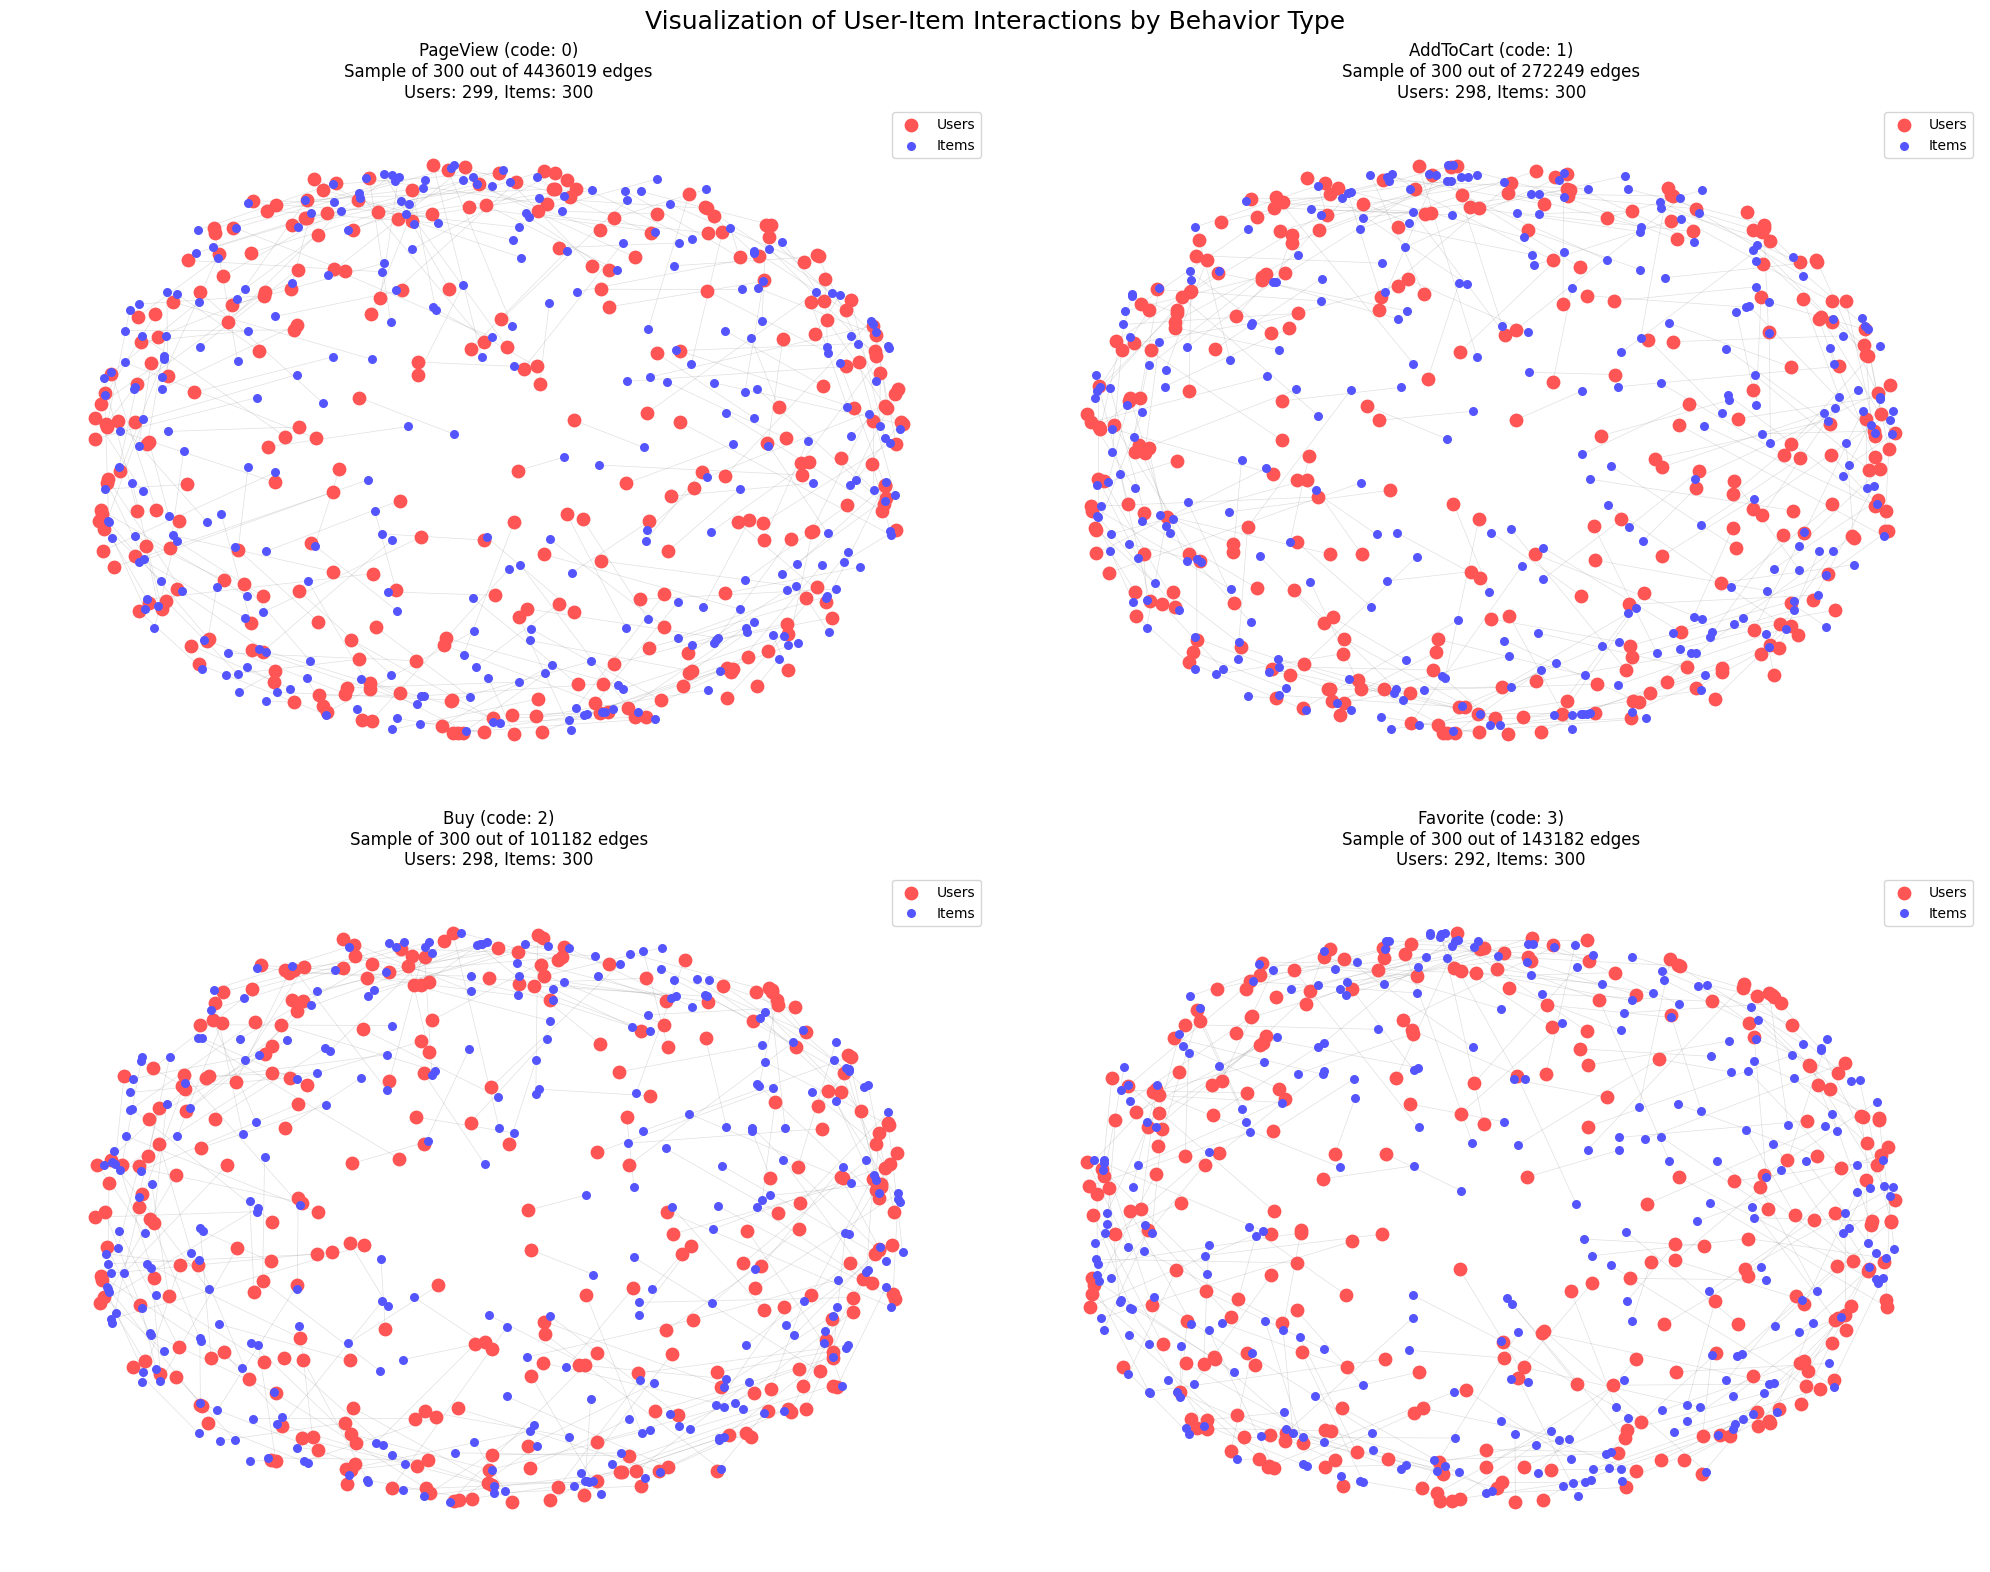


Dataset Statistics:
--------------------------------------------------
Total unique users: 49400
Total unique items: 1099089
Total interactions: 4952632
--------------------------------------------------
PageView: 4436019 interactions (89.57%)
AddToCart: 272249 interactions (5.50%)
Buy: 101182 interactions (2.04%)
Favorite: 143182 interactions (2.89%)
--------------------------------------------------
Average interactions per user: 100.26
Average interactions per item: 4.51


In [38]:
def visualize_behavior_patterns(data, behaviors_dict, sample_size=200, seed=42):
    """
    Creates a comprehensive visualization of the dataset with different behaviors.
    
    :param data: HeteroData object containing the graph
    :param behaviors_dict: Dictionary mapping behavior names to their numeric codes
    :param sample_size: Number of edges to sample for each behavior
    :param seed: Random seed for reproducibility
    """
    # Invert the behavior dictionary for displaying names
    behavior_names = {v: k for k, v in behaviors_dict.items()}
    
    # Create a figure with subplots for each behavior
    num_behaviors = len(behaviors_dict)
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    axes = axes.flatten()
    
    # Set random seed for reproducibility
    torch.manual_seed(seed)
    
    # Process each behavior type
    for behavior_idx, (behavior_name, behavior_code) in enumerate(behaviors_dict.items()):
        ax = axes[behavior_idx]
        
        # Filter edges for this behavior
        behavior_filter = data['user', 'item'].behavior == behavior_code
        behavior_edges = data['user', 'item'].edge_index[:, behavior_filter]
        
        # Count total edges for this behavior
        total_edges = behavior_edges.shape[1]
        
        # Sample a subset of edges for visualization
        if total_edges > sample_size:
            # Random sampling
            indices = torch.randperm(total_edges)[:sample_size]
            sampled_edges = behavior_edges[:, indices]
        else:
            sampled_edges = behavior_edges
        
        # Create NetworkX graph
        G = nx.Graph()
        
        # Add edges to the graph
        for i in range(sampled_edges.shape[1]):
            user_id = sampled_edges[0, i].item()
            item_id = sampled_edges[1, i].item()
            G.add_edge(f"U{user_id}", f"I{item_id}")
        
        # Calculate some graph statistics
        num_users = len([n for n in G.nodes() if n.startswith("U")])
        num_items = len([n for n in G.nodes() if n.startswith("I")])
        
        # Use a force-directed layout
        pos = nx.spring_layout(G, k=0.3, iterations=50, seed=seed)
        
        # Draw with different colors and sizes
        user_nodes = [n for n in G.nodes() if n.startswith("U")]
        item_nodes = [n for n in G.nodes() if n.startswith("I")]
        
        nx.draw_networkx_nodes(G, pos, nodelist=user_nodes, node_color='#FF5555', 
                              node_size=80, label='Users', ax=ax)
        nx.draw_networkx_nodes(G, pos, nodelist=item_nodes, node_color='#5555FF', 
                              node_size=30, label='Items', ax=ax)
        nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.3, edge_color='#999999', ax=ax)
        
        # Add title with statistics
        ax.set_title(f"{behavior_name} (code: {behavior_code})\n"
                    f"Sample of {sampled_edges.shape[1]} out of {total_edges} edges\n"
                    f"Users: {num_users}, Items: {num_items}", fontsize=12)
        
        ax.legend(fontsize=10)
        ax.axis('off')
    
    plt.suptitle("Visualization of User-Item Interactions by Behavior Type", fontsize=18)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    
    # Save the figure
    plt.savefig('behavior_patterns.png', dpi=300)
    plt.show()
    
    # Print additional dataset statistics
    print("\nDataset Statistics:")
    print("-" * 50)
    
    edge_index = data['user', 'item'].edge_index
    behaviors = data['user', 'item'].behavior
    
    total_users = len(torch.unique(edge_index[0]))
    total_items = len(torch.unique(edge_index[1]))
    total_edges = edge_index.shape[1]
    
    print(f"Total unique users: {total_users}")
    print(f"Total unique items: {total_items}")
    print(f"Total interactions: {total_edges}")
    print("-" * 50)
    
    # Behavior distribution
    for behavior_name, behavior_code in behaviors_dict.items():
        count = (behaviors == behavior_code).sum().item()
        percentage = (count / total_edges) * 100
        print(f"{behavior_name}: {count} interactions ({percentage:.2f}%)")
    
    print("-" * 50)
    
    # Calculate average interactions per user and item
    print(f"Average interactions per user: {total_edges / total_users:.2f}")
    print(f"Average interactions per item: {total_edges / total_items:.2f}")

# Define the behavior dictionary
behavior_dict = {'PageView': 0, 'AddToCart': 1, 'Buy': 2, 'Favorite': 3}

# Run the visualization
visualize_behavior_patterns(data, behavior_dict, sample_size=300)